In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing

from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score

import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.model_selection import train_test_split

target_col = "Survived"

**★訓練データと検証データを分割し、5 fold cross validationを行いながら学習**

In [9]:
def data_prep(df,mode):
    
    df['Cabin'] = df['Cabin'].fillna('Unknown') # 客室データが欠損している場合はUnknownを代入
    df['Deck'] = df['Cabin'].str.get(0) #Cabin（部屋番号）の頭文字（０番目の文字）取得
    df = df.drop("Cabin",axis=1)

    df['FamilySize'] = df['SibSp'] + df['Parch']
    df = df.drop(["SibSp", "Parch"],axis=1)
    
    #df["Fare"] = np.log(df['Fare'])
    df["Fare_log"] = np.log(df['Fare']+1)


    honorific_titles = ["Mr.", "Miss.", "Mrs.", "Master.", "Dr.", "Rev.", "Col.", "Ms.", 
              "Mlle.", "Mme.", "Capt.", "Countess.", "Major.", "Jonkheer.", "Don.", 
             "Dona.", "Sir.", "Lady."]

    # Titleを抽出
    for title in honorific_titles:
        df.loc[df.Name.str.contains(title, regex=False), "honorific_titles"] = title
    
    target_col_list = ["Embarked","Sex","honorific_titles","Deck"]
    if mode == "xgb":#XGBost用ラベルエンコーディング
        le = preprocessing.LabelEncoder()
        for col in target_col_list:
            le.fit(df[col])
            df[col] = le.transform(df[col])
    elif mode == "lgbm":#LightGBM用ラベルエンコーディング
         for col in target_col_list:
            df[col] = df[col].astype("category")
    else:
        pass
        
    #不要カラム削除
    df = df.drop(["Name","Ticket","Fare"],axis=1)
    #df = df.drop(["Name","Ticket","PassengerId"],axis=1)
    return df


In [10]:

train = pd.read_csv("/kaggle/input/titanic/train.csv")
test = pd.read_csv("/kaggle/input/titanic/test.csv")

train = data_prep(train,"xgb")
test = data_prep(test,"xgb")

X_train = train.drop(target_col,axis=1) # 説明変数
y_train = train[target_col] # 目的変数(来店数)

feature_names = X_train.columns.tolist()
print(feature_names)


['PassengerId', 'Pclass', 'Sex', 'Age', 'Embarked', 'Deck', 'FamilySize', 'Fare_log', 'honorific_titles']


In [11]:
X_train.head()

,PassengerId,Pclass,Sex,Age,Embarked,Deck,FamilySize,Fare_log,honorific_titles
0,1,3,1,22.0,2,8,1,2.110213,12
1,2,1,0,38.0,0,2,1,4.280593,13
2,3,3,0,26.0,2,8,0,2.188856,9
3,4,1,0,35.0,2,2,1,3.990834,13
4,5,3,1,35.0,2,8,0,2.202765,12


In [4]:
# pro

NFOLD = 5
SEED = 42
NROUND = 100000
ESR = 20
LOGLEVEL = 50

# test
'''
NFOLD = 3
SEED = 42
NROUND = 1000
ESR = 20
LOGLEVEL = 10
'''

'\nNFOLD = 3\nSEED = 42\nNROUND = 1000\nESR = 20\nLOGLEVEL = 10\n'

In [5]:
def stratified(X_train, y_train):
    trn_idx_list = []
    val_idx_list = []
    folds = StratifiedKFold(
        n_splits = NFOLD,
        shuffle = True,
        random_state = SEED
    )
    return list(folds.split(X_train.values, y_train.values))

In [12]:
cv = stratified(X_train,y_train)
#cv

In [13]:
#パラメータについて: https://qiita.com/FJyusk56/items/0649f4362587261bd57a

params = {
    "objective":"binary:logistic",# 最小化させるべき損失関数.(2項分類で確率を返す)
    "eval_metoric":"logloss",# テストデータに対する評価指標
    "max_depth":4,
    "random_state":42,
    "verbosity":0,# 学習中のコマンドライン出力（0から2に大きくなるにつれ経過表示が細かくなる）
    "silent":1 # 0:起動中のメッセージを出力
}

out_put_preds = np.zeros(len(y_train))

importances = pd.DataFrame()

#valのlogloss保存用
score_logloss = []

#valのaccuracy保存用
score_acc = []


# N Fold CVで学習
for i, (trn_idx, val_idx) in enumerate(cv):
    print(f'\nFold: {i} start prediction.')
    
    trn_x, trn_y = X_train.iloc[trn_idx],y_train[trn_idx]
    val_x, val_y = X_train.iloc[val_idx],y_train[val_idx]
    
    #この処理を挟むことで省メモリに学習できる
    dtrain = xgb.DMatrix(trn_x, label=trn_y)
    dvalid = xgb.DMatrix(val_x, label=val_y)
    
    #モデルのfit
    model = xgb.train(
        params,
        dtrain = dtrain,
        num_boost_round = NROUND,
        evals=[(dtrain,"train"),(dvalid,"valid")],
        early_stopping_rounds = ESR,
        verbose_eval = LOGLEVEL
    )
    
    # out of fold法を用いて訓練データの予測を行う
    val_preds = model.predict(xgb.DMatrix(val_x), ntree_limit=model.best_ntree_limit)
    out_put_preds[val_idx] = val_preds
    
    #各foldのvalのloglossを保存
    logloss = log_loss(val_y,val_preds)
    score_logloss.append(logloss)
    
    val_pred_for_acc = np.where(val_preds >0.5,1,0)
    acc = accuracy_score(val_y,val_pred_for_acc)
    score_acc.append(acc)
    
    #各foldのimportanceを保存
    score_dict = model.get_score(importance_type="gain")
    imp_df = pd.DataFrame({
        "feature":list(score_dict.keys()),
        "gain":list(score_dict.values()),
        "fold":i
    }
    )
    importances = pd.concat([importances,imp_df],axis=0)
    
#各loglossのvalのloglossの平均をプリント
logloss = np.mean(score_logloss)

#各accuracyのvalのaccuracyの平均をプリント
accuracy = np.mean(score_acc)

print(f'val_loglss_mean: {logloss:.4f}')
print(f'val_accuracy_mean: {accuracy:.3f}')

    


Fold: 0 start prediction.
[0]	train-logloss:0.56315	valid-logloss:0.57124
[50]	train-logloss:0.19018	valid-logloss:0.36460
[67]	train-logloss:0.15149	valid-logloss:0.37102

Fold: 1 start prediction.
[0]	train-logloss:0.55952	valid-logloss:0.57905
[50]	train-logloss:0.16680	valid-logloss:0.39151
[53]	train-logloss:0.16044	valid-logloss:0.39413

Fold: 2 start prediction.
[0]	train-logloss:0.55731	valid-logloss:0.58823
[27]	train-logloss:0.22659	valid-logloss:0.48061

Fold: 3 start prediction.
[0]	train-logloss:0.56192	valid-logloss:0.57293
[38]	train-logloss:0.19388	valid-logloss:0.42190

Fold: 4 start prediction.
[0]	train-logloss:0.55936	valid-logloss:0.56759
[32]	train-logloss:0.22294	valid-logloss:0.40821
val_loglss_mean: 0.3940
val_accuracy_mean: 0.834


In [14]:
importances.head()

,feature,gain,fold
0,PassengerId,0.939705,0
1,Pclass,7.304872,0
2,Sex,19.063843,0
3,Age,1.250588,0
4,Embarked,0.978082,0


<AxesSubplot:xlabel='gain', ylabel='feature'>

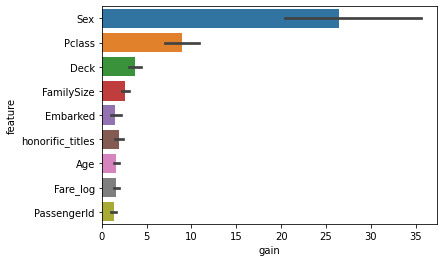

In [15]:
sns.barplot(x='gain',y='feature',data=importances.sort_values('gain',ascending=False))

In [79]:
#predictで予測
dtest = xgb.DMatrix(test)
y_pred_proba = model.predict(dtest)
y_pred= np.where(y_pred_proba > 0.5,1,0)

#データフレームを作成
submission = pd.DataFrame({'PassengerId':test['PassengerId'], 'Survived':y_pred})
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [80]:
submission.to_csv('submission.csv', index=False)

# LightGBM

In [86]:
train = pd.read_csv("/kaggle/input/titanic/train.csv")
test = pd.read_csv("/kaggle/input/titanic/test.csv")

train = data_prep(train,"lgbm")
test = data_prep(test,"lgbm")

X_train = train.drop(target_col,axis=1) # 説明変数
y_train = train[target_col] # 目的変数(来店数)

cv = stratified(X_train,y_train)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   PassengerId       891 non-null    int64   
 1   Pclass            891 non-null    int64   
 2   Sex               891 non-null    category
 3   Age               714 non-null    float64 
 4   Fare              891 non-null    float64 
 5   Embarked          889 non-null    category
 6   FamilySize        891 non-null    int64   
 7   honorific_titles  891 non-null    category
dtypes: category(3), float64(2), int64(3)
memory usage: 38.5 KB


In [94]:
#パラメータについて: https://qiita.com/FJyusk56/items/0649f4362587261bd57a

params = {
    "objective":"binary",# 最小化させるべき損失関数.(2項分類で確率を返す)
    "metoric":"binary_logloss",# テストデータに対する評価指標
    "learning_rate":0.01,
    "max_depth":4,
    "num_leaves":32,
    "random_state":42,
    "verbosity":-1,# 学習中のコマンドライン出力（0から2に大きくなるにつれ経過表示が細かくなる）
}

out_put_preds = np.zeros(len(y_train))

importances = pd.DataFrame()

#valのlogloss保存用
score_logloss = []


# N Fold CVで学習
for i, (trn_idx, val_idx) in enumerate(cv):
    print(f'\nFold: {i} start prediction.')
    
    trn_x, trn_y = X_train.iloc[trn_idx],y_train[trn_idx]
    val_x, val_y = X_train.iloc[val_idx],y_train[val_idx]
    
    #この処理を挟むことで省メモリに学習できる
    dtrain = lgb.Dataset(trn_x, label=trn_y)
    dvalid = lgb.Dataset(val_x, label=val_y)
    
    #モデルのfit
    model = lgb.train(
        params,
        train_set = dtrain,
        num_boost_round = NROUND,
        valid_sets=[dtrain,dvalid],
        valid_names=["training","valid"],
        early_stopping_rounds = ESR,
        verbose_eval = LOGLEVEL
    )
    
    # out of fold法を用いて訓練データの予測を行う
    val_preds = model.predict(val_x, num_iteration=model.best_iteration)
    out_put_preds[val_idx] = val_preds
    
    #各foldのvalのloglossを保存
    logloss = log_loss(val_y,val_preds)
    score_logloss.append(logloss)
    #各foldのimportanceを保存
    #score_dict = model.get_score(importance_type="gain")
    imp_df = pd.DataFrame({
        "feature":model.feature_name(),
        "gain":model.feature_importance(importance_type="gain"),
        "fold":i
    }
    )
    importances = pd.concat([importances,imp_df],axis=0)
    
#各loglossのvalのloglossの平均をプリント
logloss = np.mean(score_logloss)
print(f'val_loglss_mean: {logloss:.4f}')

    


Fold: 0 start prediction.
[  0   1   2   3   5   7   8   9  10  11  12  14  15  16  17  18  20  21
  22  23  25  27  29  32  33  35  36  37  38  39  40  41  42  44  46  47
  48  49  50  51  52  54  56  57  58  59  61  62  65  67  69  70  71  72
  73  74  76  77  78  80  81  82  83  84  85  86  87  88  89  91  92  93
  95  96  97  98 100 101 102 104 106 107 109 110 111 112 115 116 117 119
 120 121 122 123 124 125 127 129 130 132 133 135 136 137 138 139 140 142
 144 145 149 151 152 154 156 157 158 159 160 161 162 163 165 166 167 168
 169 171 172 175 178 179 180 181 182 183 184 185 186 187 188 189 190 191
 192 193 194 195 196 197 198 199 200 201 202 204 205 206 208 209 210 211
 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229
 230 231 232 233 234 236 237 239 240 241 242 243 244 245 246 247 248 250
 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269
 270 271 272 274 275 276 277 278 279 280 281 284 288 289 291 292 294 295
 296 297 298 299 300 301

<AxesSubplot:xlabel='gain', ylabel='feature'>

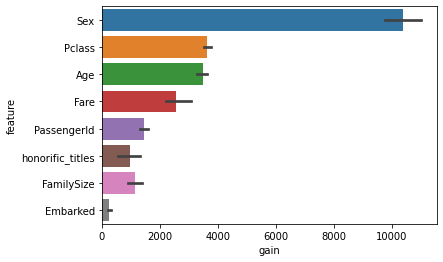

In [70]:
sns.barplot(x='gain',y='feature',data=importances.sort_values('gain',ascending=False))

In [93]:
#predictで予測
y_pred_proba = model.predict(test)
y_pred= np.where(y_pred_proba > 0.5,1,0)

#データフレームを作成
submission = pd.DataFrame({'PassengerId':test['PassengerId'], 'Survived':y_pred})
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


# Optunaでのハイパーパラメータチューニング

optunaについて
https://tech.preferred.jp/ja/blog/optuna-release/

→ 具体的には、Tree-structured Parzen Estimator というベイズ最適化アルゴリズムの一種。

※調整するパラメータを増やすほど、汎か性能が落ちている(今回の場合)

In [10]:
train = pd.read_csv("/kaggle/input/titanic/train.csv")
test = pd.read_csv("/kaggle/input/titanic/test.csv")

train = data_prep(train,"xgb")
test = data_prep(test,"xgb")

X_train = train.drop(target_col,axis=1) # 説明変数
y_train = train[target_col] # 目的変数(来店数)

cv = stratified(X_train,y_train)

In [13]:
#cv[0][0]

trn_x, trn_y = X_train.iloc[cv[0][0]],y_train[cv[0][0]]

trn_x.head(10)

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Deck,FamilySize,honorific_titles
0,1,3,1,22.0,2.110213,2,8,1,12
1,2,1,0,38.0,4.280593,0,2,1,13
2,3,3,0,26.0,2.188856,2,8,0,9
3,4,1,0,35.0,3.990834,2,2,1,13
5,6,3,1,NaN,2.246893,1,8,0,12
7,8,3,1,2.0,3.094446,2,8,4,8
8,9,3,0,27.0,2.495954,2,8,2,13
9,10,2,0,14.0,3.436268,0,8,1,13
10,11,3,0,4.0,2.873565,2,6,2,9
11,12,1,0,58.0,3.316003,2,2,0,9


In [107]:
trn_y.head(10)

0     0
1     1
2     1
3     1
5     0
7     0
8     1
9     1
10    1
11    1
Name: Survived, dtype: int64

In [17]:
import optuna # ハイパーパラメーターのチューニングのため
from xgboost import XGBClassifier

def run(trial):
    params = {
    "objective":"binary:logistic",# 最小化させるべき損失関数.(2項分類で確率を返す)
    "eval_metoric":"logloss",# テストデータに対する評価指標
    #"max_depth":4,
    "random_state":42,
    "verbosity":0,# 学習中のコマンドライン出力（0から2に大きくなるにつれ経過表示が細かくなる）
    "silent":1 # 0:起動中のメッセージを出力
    }
    fold = 0
    # 各ハイパーパラメーターの提案値を取得
    learning_rate = trial.suggest_float('learning_rate', 1e-2, 0.25, log=True)
    #reg_lambda = trial.suggest_float('reg_lambda', 1e-8, 100.0)
    #reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 100.0)
    #subsample = trial.suggest_float('subsample', 0.1, 1.0)
    #colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 1.0)
    max_depth = trial.suggest_int('max_depth', 2, 6)
    
    trn_x, trn_y = X_train.iloc[cv[fold][0]],y_train[cv[fold][0]]
    val_x, val_y = X_train.iloc[cv[fold][1]],y_train[cv[fold][1]]
    
    #この処理を挟むことで省メモリに学習できる
    dtrain = xgb.DMatrix(trn_x, label=trn_y)
    dvalid = xgb.DMatrix(val_x, label=val_y)
    
    
    model=XGBClassifier(
        eval_metric="logloss",
        n_estimators=NROUND, # 早期停止（Early Stopping）するのでチューニングは不要
        # 定義したチューニング対象を各ハイパーパラメーターの引数に指定
        #subsample=subsample,
        #colsample_bytree=colsample_bytree,
        learning_rate=learning_rate,
        max_depth=max_depth)
    
    model.fit(
    trn_x, trn_y,
    early_stopping_rounds=ESR, 
    eval_set=[(val_x, val_y)], # 早期停止するため検証データも指定
    verbose=1000) # 1000個目のestimatorsごとに出力
    '''
    #モデルのfit
    model = xgb.train(
        params,
        dtrain = dtrain,
        num_boost_round = NROUND,
        evals=[(dtrain,"train"),(dvalid,"valid")],
        early_stopping_rounds = ESR,
        verbose_eval = LOGLEVEL,
        # 定義したチューニング対象を各ハイパーパラメーターの引数に指定
        max_depth = max_depth,
        learning_rate = learning_rate
    )
    '''
    # 検証データをモデルに入力して予測する
    val_preds = model.predict(val_x, ntree_limit=model.best_ntree_limit)
    
    #foldのvalのlogloss(スコア)算出
    logloss = log_loss(val_y,val_preds)
    
    #この評価値に基づき、
    #Optunaがハイパーパラメーターを自動的にチューニングしてくれる仕組み
    return logloss
                                

In [18]:
study = optuna.create_study(direction='minimize')

#run()関数を5回呼び出しながら各ハイパーパラメーターを最適化
#5回は少ないので、本来は500回などもう少し多い回数を指定するとよい
#study.optimize(run, n_trials=5)

study.optimize(run, n_trials=100)

[I 2022-11-22 09:15:38,978] A new study created in memory with name: no-name-d335e420-fd45-4ae8-8bae-99d1bd2b78b2


[0]	validation_0-logloss:0.67494
[103]	validation_0-logloss:0.38789


[I 2022-11-22 09:15:39,555] Trial 0 finished with value: 5.402762763291794 and parameters: {'learning_rate': 0.038913194423697166, 'max_depth': 4}. Best is trial 0 with value: 5.402762763291794.


[0]	validation_0-logloss:0.64223
[56]	validation_0-logloss:0.38672


[I 2022-11-22 09:15:39,882] Trial 1 finished with value: 5.402762763291794 and parameters: {'learning_rate': 0.11310636571038951, 'max_depth': 4}. Best is trial 0 with value: 5.402762763291794.


[0]	validation_0-logloss:0.68210
[227]	validation_0-logloss:0.36565


[I 2022-11-22 09:15:41,144] Trial 2 finished with value: 4.823887188001166 and parameters: {'learning_rate': 0.023597762654928564, 'max_depth': 6}. Best is trial 2 with value: 4.823887188001166.


[0]	validation_0-logloss:0.68638
[300]	validation_0-logloss:0.38223


[I 2022-11-22 09:15:42,573] Trial 3 finished with value: 5.402749362217546 and parameters: {'learning_rate': 0.013923976857808287, 'max_depth': 5}. Best is trial 2 with value: 4.823887188001166.


[0]	validation_0-logloss:0.63158
[134]	validation_0-logloss:0.36872


[I 2022-11-22 09:15:43,184] Trial 4 finished with value: 4.630937596953788 and parameters: {'learning_rate': 0.1386331647183102, 'max_depth': 4}. Best is trial 4 with value: 4.630937596953788.


[0]	validation_0-logloss:0.61705
[80]	validation_0-logloss:0.37410


[I 2022-11-22 09:15:43,555] Trial 5 finished with value: 5.209804238194919 and parameters: {'learning_rate': 0.19357139099217366, 'max_depth': 2}. Best is trial 4 with value: 4.630937596953788.


[0]	validation_0-logloss:0.67028
[189]	validation_0-logloss:0.37121


[I 2022-11-22 09:15:44,444] Trial 6 finished with value: 4.823891655025915 and parameters: {'learning_rate': 0.04794110260877287, 'max_depth': 5}. Best is trial 4 with value: 4.630937596953788.


[0]	validation_0-logloss:0.67425
[139]	validation_0-logloss:0.37995


[I 2022-11-22 09:15:45,126] Trial 7 finished with value: 5.20979530414542 and parameters: {'learning_rate': 0.039426200181122854, 'max_depth': 5}. Best is trial 4 with value: 4.630937596953788.


[0]	validation_0-logloss:0.61019
[111]	validation_0-logloss:0.36257


[I 2022-11-22 09:15:45,619] Trial 8 finished with value: 4.630937596953789 and parameters: {'learning_rate': 0.21327955311480717, 'max_depth': 2}. Best is trial 4 with value: 4.630937596953788.


[0]	validation_0-logloss:0.67628
[427]	validation_0-logloss:0.36956


[I 2022-11-22 09:15:47,412] Trial 9 finished with value: 4.630928662904289 and parameters: {'learning_rate': 0.03708357416924852, 'max_depth': 3}. Best is trial 9 with value: 4.630928662904289.


[0]	validation_0-logloss:0.68852
[626]	validation_0-logloss:0.37683


[I 2022-11-22 09:15:50,168] Trial 10 finished with value: 5.016845713098042 and parameters: {'learning_rate': 0.010029454949354366, 'max_depth': 3}. Best is trial 9 with value: 4.630928662904289.


[0]	validation_0-logloss:0.65294
[137]	validation_0-logloss:0.37192


[I 2022-11-22 09:15:50,777] Trial 11 finished with value: 5.209808705219667 and parameters: {'learning_rate': 0.09083991731389071, 'max_depth': 3}. Best is trial 9 with value: 4.630928662904289.


[0]	validation_0-logloss:0.64665
[109]	validation_0-logloss:0.37555


[I 2022-11-22 09:15:51,264] Trial 12 finished with value: 5.209804238194919 and parameters: {'learning_rate': 0.10588206093591547, 'max_depth': 3}. Best is trial 9 with value: 4.630928662904289.


[0]	validation_0-logloss:0.66186
[174]	validation_0-logloss:0.37070


[I 2022-11-22 09:15:52,035] Trial 13 finished with value: 5.402762763291794 and parameters: {'learning_rate': 0.0699433468234785, 'max_depth': 3}. Best is trial 9 with value: 4.630928662904289.


[0]	validation_0-logloss:0.62807
[44]	validation_0-logloss:0.39091


[I 2022-11-22 09:15:52,279] Trial 14 finished with value: 5.595716821363921 and parameters: {'learning_rate': 0.14720240758493341, 'max_depth': 4}. Best is trial 9 with value: 4.630928662904289.


[0]	validation_0-logloss:0.67975
[418]	validation_0-logloss:0.37096


[I 2022-11-22 09:15:54,027] Trial 15 finished with value: 5.595721288388671 and parameters: {'learning_rate': 0.03134350320531575, 'max_depth': 2}. Best is trial 9 with value: 4.630928662904289.


[0]	validation_0-logloss:0.66333
[96]	validation_0-logloss:0.36839


[I 2022-11-22 09:15:54,542] Trial 16 finished with value: 5.016845713098042 and parameters: {'learning_rate': 0.06515990538147477, 'max_depth': 6}. Best is trial 9 with value: 4.630928662904289.


[0]	validation_0-logloss:0.68404
[334]	validation_0-logloss:0.37659


[I 2022-11-22 09:15:56,014] Trial 17 finished with value: 5.016845713098042 and parameters: {'learning_rate': 0.01985416053132267, 'max_depth': 3}. Best is trial 9 with value: 4.630928662904289.


[0]	validation_0-logloss:0.66227
[71]	validation_0-logloss:0.38702


[I 2022-11-22 09:15:56,380] Trial 18 finished with value: 5.402762763291794 and parameters: {'learning_rate': 0.06695951677454122, 'max_depth': 4}. Best is trial 9 with value: 4.630928662904289.


[0]	validation_0-logloss:0.62561
[94]	validation_0-logloss:0.37194


[I 2022-11-22 09:15:56,859] Trial 19 finished with value: 5.016850180122792 and parameters: {'learning_rate': 0.1497361548605818, 'max_depth': 5}. Best is trial 9 with value: 4.630928662904289.


[0]	validation_0-logloss:0.68054
[363]	validation_0-logloss:0.37171


[I 2022-11-22 09:15:58,431] Trial 20 finished with value: 5.209804238194918 and parameters: {'learning_rate': 0.02758763837923425, 'max_depth': 3}. Best is trial 9 with value: 4.630928662904289.


[0]	validation_0-logloss:0.60000
[197]	validation_0-logloss:0.35004


[I 2022-11-22 09:15:59,283] Trial 21 finished with value: 4.630937596953789 and parameters: {'learning_rate': 0.24344475841849658, 'max_depth': 2}. Best is trial 9 with value: 4.630928662904289.


[0]	validation_0-logloss:0.62768
[84]	validation_0-logloss:0.37232


[I 2022-11-22 09:15:59,702] Trial 22 finished with value: 5.016850180122792 and parameters: {'learning_rate': 0.16391727083012186, 'max_depth': 2}. Best is trial 9 with value: 4.630928662904289.


[0]	validation_0-logloss:0.59865
[61]	validation_0-logloss:0.36971


[I 2022-11-22 09:16:00,005] Trial 23 finished with value: 5.016850180122792 and parameters: {'learning_rate': 0.24751058260205167, 'max_depth': 2}. Best is trial 9 with value: 4.630928662904289.


[0]	validation_0-logloss:0.64069
[68]	validation_0-logloss:0.37338


[I 2022-11-22 09:16:00,354] Trial 24 finished with value: 4.630937596953789 and parameters: {'learning_rate': 0.12035267908907615, 'max_depth': 3}. Best is trial 9 with value: 4.630928662904289.


[0]	validation_0-logloss:0.65115
[118]	validation_0-logloss:0.38290


[I 2022-11-22 09:16:00,939] Trial 25 finished with value: 5.402767230316544 and parameters: {'learning_rate': 0.09227941570771457, 'max_depth': 4}. Best is trial 9 with value: 4.630928662904289.


[0]	validation_0-logloss:0.61781
[54]	validation_0-logloss:0.37279


[I 2022-11-22 09:16:01,218] Trial 26 finished with value: 5.209799771170169 and parameters: {'learning_rate': 0.19141765309110698, 'max_depth': 2}. Best is trial 9 with value: 4.630928662904289.


[0]	validation_0-logloss:0.63817
[124]	validation_0-logloss:0.36586


[I 2022-11-22 09:16:01,783] Trial 27 finished with value: 4.823891655025915 and parameters: {'learning_rate': 0.12654413327628286, 'max_depth': 3}. Best is trial 9 with value: 4.630928662904289.


[0]	validation_0-logloss:0.67001
[117]	validation_0-logloss:0.38747


[I 2022-11-22 09:16:02,359] Trial 28 finished with value: 5.209808705219667 and parameters: {'learning_rate': 0.04974210732785911, 'max_depth': 4}. Best is trial 9 with value: 4.630928662904289.


[0]	validation_0-logloss:0.60070
[78]	validation_0-logloss:0.36820


[I 2022-11-22 09:16:02,730] Trial 29 finished with value: 5.402762763291794 and parameters: {'learning_rate': 0.24132919777535822, 'max_depth': 2}. Best is trial 9 with value: 4.630928662904289.


[0]	validation_0-logloss:0.65667
[93]	validation_0-logloss:0.38597


[I 2022-11-22 09:16:03,186] Trial 30 finished with value: 5.402762763291794 and parameters: {'learning_rate': 0.07961372707061155, 'max_depth': 4}. Best is trial 9 with value: 4.630928662904289.


[0]	validation_0-logloss:0.67597
[315]	validation_0-logloss:0.37344


[I 2022-11-22 09:16:05,479] Trial 31 finished with value: 5.209804238194919 and parameters: {'learning_rate': 0.03777883642615107, 'max_depth': 3}. Best is trial 9 with value: 4.630928662904289.


[0]	validation_0-logloss:0.61610
[86]	validation_0-logloss:0.37195


[I 2022-11-22 09:16:05,887] Trial 32 finished with value: 5.402762763291794 and parameters: {'learning_rate': 0.1962797548484248, 'max_depth': 2}. Best is trial 9 with value: 4.630928662904289.


[0]	validation_0-logloss:0.63964
[88]	validation_0-logloss:0.37703


[I 2022-11-22 09:16:06,304] Trial 33 finished with value: 5.209804238194918 and parameters: {'learning_rate': 0.1229247508556302, 'max_depth': 3}. Best is trial 9 with value: 4.630928662904289.


[0]	validation_0-logloss:0.61057
[162]	validation_0-logloss:0.35867


[I 2022-11-22 09:16:07,008] Trial 34 finished with value: 4.823891655025915 and parameters: {'learning_rate': 0.21216410487010756, 'max_depth': 2}. Best is trial 9 with value: 4.630928662904289.


[0]	validation_0-logloss:0.62157
[53]	validation_0-logloss:0.39015


[I 2022-11-22 09:16:07,285] Trial 35 finished with value: 5.4027716973412945 and parameters: {'learning_rate': 0.1632980249714328, 'max_depth': 4}. Best is trial 9 with value: 4.630928662904289.


[0]	validation_0-logloss:0.66784
[209]	validation_0-logloss:0.36955


[I 2022-11-22 09:16:08,214] Trial 36 finished with value: 5.016845713098042 and parameters: {'learning_rate': 0.056180592897172095, 'max_depth': 3}. Best is trial 9 with value: 4.630928662904289.


[0]	validation_0-logloss:0.64630
[66]	validation_0-logloss:0.37799


[I 2022-11-22 09:16:08,578] Trial 37 finished with value: 4.823887188001166 and parameters: {'learning_rate': 0.1010708184976255, 'max_depth': 5}. Best is trial 9 with value: 4.630928662904289.


[0]	validation_0-logloss:0.63480
[130]	validation_0-logloss:0.37563


[I 2022-11-22 09:16:09,186] Trial 38 finished with value: 5.5957257554134205 and parameters: {'learning_rate': 0.13083455861260745, 'max_depth': 4}. Best is trial 9 with value: 4.630928662904289.


[0]	validation_0-logloss:0.68507
[518]	validation_0-logloss:0.37475


[I 2022-11-22 09:16:11,470] Trial 39 finished with value: 5.402758296267045 and parameters: {'learning_rate': 0.018770311929452648, 'max_depth': 2}. Best is trial 9 with value: 4.630928662904289.


[0]	validation_0-logloss:0.67699
[135]	validation_0-logloss:0.37979


[I 2022-11-22 09:16:12,166] Trial 40 finished with value: 5.595707887314423 and parameters: {'learning_rate': 0.033611761368449754, 'max_depth': 5}. Best is trial 9 with value: 4.630928662904289.


[0]	validation_0-logloss:0.62489
[237]	validation_0-logloss:0.35130


[I 2022-11-22 09:16:13,144] Trial 41 finished with value: 4.630933129929039 and parameters: {'learning_rate': 0.17160024254486844, 'max_depth': 2}. Best is trial 9 with value: 4.630928662904289.


[0]	validation_0-logloss:0.61872
[87]	validation_0-logloss:0.36576


[I 2022-11-22 09:16:13,557] Trial 42 finished with value: 4.823891655025915 and parameters: {'learning_rate': 0.17583116456594503, 'max_depth': 3}. Best is trial 9 with value: 4.630928662904289.


[0]	validation_0-logloss:0.63761
[107]	validation_0-logloss:0.37036


[I 2022-11-22 09:16:14,034] Trial 43 finished with value: 5.209808705219668 and parameters: {'learning_rate': 0.1371143843237405, 'max_depth': 2}. Best is trial 9 with value: 4.630928662904289.


[0]	validation_0-logloss:0.60492
[169]	validation_0-logloss:0.35322


[I 2022-11-22 09:16:14,739] Trial 44 finished with value: 4.630937596953789 and parameters: {'learning_rate': 0.22873323075351878, 'max_depth': 2}. Best is trial 9 with value: 4.630928662904289.


[0]	validation_0-logloss:0.64390
[122]	validation_0-logloss:0.36815


[I 2022-11-22 09:16:15,294] Trial 45 finished with value: 4.823887188001165 and parameters: {'learning_rate': 0.11252292567729577, 'max_depth': 3}. Best is trial 9 with value: 4.630928662904289.


[0]	validation_0-logloss:0.66025
[170]	validation_0-logloss:0.37057


[I 2022-11-22 09:16:16,046] Trial 46 finished with value: 5.402767230316544 and parameters: {'learning_rate': 0.07882083300563732, 'max_depth': 2}. Best is trial 9 with value: 4.630928662904289.


[0]	validation_0-logloss:0.61638
[42]	validation_0-logloss:0.37569


[I 2022-11-22 09:16:16,296] Trial 47 finished with value: 4.437974604832163 and parameters: {'learning_rate': 0.17919349519625186, 'max_depth': 6}. Best is trial 47 with value: 4.437974604832163.


[0]	validation_0-logloss:0.67387
[161]	validation_0-logloss:0.36640


[I 2022-11-22 09:16:17,130] Trial 48 finished with value: 4.823891655025916 and parameters: {'learning_rate': 0.04156670510222706, 'max_depth': 6}. Best is trial 47 with value: 4.437974604832163.


[0]	validation_0-logloss:0.61654
[46]	validation_0-logloss:0.36997


[I 2022-11-22 09:16:17,429] Trial 49 finished with value: 4.630933129929039 and parameters: {'learning_rate': 0.17878805874858747, 'max_depth': 6}. Best is trial 47 with value: 4.437974604832163.


[0]	validation_0-logloss:0.62754
[47]	validation_0-logloss:0.38264


[I 2022-11-22 09:16:17,704] Trial 50 finished with value: 5.402753829242296 and parameters: {'learning_rate': 0.15057802004851084, 'max_depth': 6}. Best is trial 47 with value: 4.437974604832163.


[0]	validation_0-logloss:0.61521
[69]	validation_0-logloss:0.37692


[I 2022-11-22 09:16:18,071] Trial 51 finished with value: 4.823896122050665 and parameters: {'learning_rate': 0.18226309035483562, 'max_depth': 6}. Best is trial 47 with value: 4.437974604832163.


[0]	validation_0-logloss:0.60179
[40]	validation_0-logloss:0.37251


[I 2022-11-22 09:16:18,306] Trial 52 finished with value: 5.209795304145419 and parameters: {'learning_rate': 0.2096062277671673, 'max_depth': 5}. Best is trial 47 with value: 4.437974604832163.


[0]	validation_0-logloss:0.62023
[79]	validation_0-logloss:0.37757


[I 2022-11-22 09:16:18,723] Trial 53 finished with value: 5.209813172244417 and parameters: {'learning_rate': 0.16921596907842695, 'max_depth': 6}. Best is trial 47 with value: 4.437974604832163.


[0]	validation_0-logloss:0.60134
[43]	validation_0-logloss:0.36350


[I 2022-11-22 09:16:18,974] Trial 54 finished with value: 4.63093312992904 and parameters: {'learning_rate': 0.2195791129313293, 'max_depth': 6}. Best is trial 47 with value: 4.437974604832163.


[0]	validation_0-logloss:0.62721
[45]	validation_0-logloss:0.37301


[I 2022-11-22 09:16:19,241] Trial 55 finished with value: 5.016845713098042 and parameters: {'learning_rate': 0.15140728791654093, 'max_depth': 6}. Best is trial 47 with value: 4.437974604832163.


[0]	validation_0-logloss:0.60313
[64]	validation_0-logloss:0.36096


[I 2022-11-22 09:16:19,587] Trial 56 finished with value: 4.437988005906412 and parameters: {'learning_rate': 0.2146525320163125, 'max_depth': 6}. Best is trial 47 with value: 4.437974604832163.


[0]	validation_0-logloss:0.68252
[177]	validation_0-logloss:0.36963


[I 2022-11-22 09:16:20,535] Trial 57 finished with value: 4.823882720976417 and parameters: {'learning_rate': 0.022679007885871374, 'max_depth': 6}. Best is trial 47 with value: 4.437974604832163.


[0]	validation_0-logloss:0.60227
[61]	validation_0-logloss:0.37706


[I 2022-11-22 09:16:20,879] Trial 58 finished with value: 5.209799771170169 and parameters: {'learning_rate': 0.21700378027411232, 'max_depth': 6}. Best is trial 47 with value: 4.437974604832163.


[0]	validation_0-logloss:0.68814
[465]	validation_0-logloss:0.36714


[I 2022-11-22 09:16:23,446] Trial 59 finished with value: 5.016845713098043 and parameters: {'learning_rate': 0.0106095359602001, 'max_depth': 6}. Best is trial 47 with value: 4.437974604832163.


[0]	validation_0-logloss:0.61009
[36]	validation_0-logloss:0.38757


[I 2022-11-22 09:16:23,696] Trial 60 finished with value: 4.823882720976417 and parameters: {'learning_rate': 0.1882185257080069, 'max_depth': 5}. Best is trial 47 with value: 4.437974604832163.


[0]	validation_0-logloss:0.63154
[96]	validation_0-logloss:0.37216


[I 2022-11-22 09:16:24,243] Trial 61 finished with value: 5.595721288388672 and parameters: {'learning_rate': 0.14056857442094253, 'max_depth': 6}. Best is trial 47 with value: 4.437974604832163.


[0]	validation_0-logloss:0.60749
[54]	validation_0-logloss:0.38328


[I 2022-11-22 09:16:24,588] Trial 62 finished with value: 5.402767230316544 and parameters: {'learning_rate': 0.20278953335516176, 'max_depth': 6}. Best is trial 47 with value: 4.437974604832163.


[0]	validation_0-logloss:0.62166
[71]	validation_0-logloss:0.37561


[I 2022-11-22 09:16:24,998] Trial 63 finished with value: 5.402762763291795 and parameters: {'learning_rate': 0.15934986090562434, 'max_depth': 5}. Best is trial 47 with value: 4.437974604832163.


[0]	validation_0-logloss:0.67217
[141]	validation_0-logloss:0.36525


[I 2022-11-22 09:16:25,795] Trial 64 finished with value: 5.016845713098043 and parameters: {'learning_rate': 0.04534330602220421, 'max_depth': 6}. Best is trial 47 with value: 4.437974604832163.


[0]	validation_0-logloss:0.58816
[38]	validation_0-logloss:0.37811


[I 2022-11-22 09:16:26,046] Trial 65 finished with value: 5.402749362217546 and parameters: {'learning_rate': 0.24609079416180982, 'max_depth': 5}. Best is trial 47 with value: 4.437974604832163.


[0]	validation_0-logloss:0.61577
[55]	validation_0-logloss:0.38089


[I 2022-11-22 09:16:26,397] Trial 66 finished with value: 5.016850180122792 and parameters: {'learning_rate': 0.18081170712415268, 'max_depth': 6}. Best is trial 47 with value: 4.437974604832163.


[0]	validation_0-logloss:0.68033
[201]	validation_0-logloss:0.36825


[I 2022-11-22 09:16:27,462] Trial 67 finished with value: 5.016845713098043 and parameters: {'learning_rate': 0.027435193877654578, 'max_depth': 6}. Best is trial 47 with value: 4.437974604832163.


[0]	validation_0-logloss:0.66453
[112]	validation_0-logloss:0.37634


[I 2022-11-22 09:16:28,020] Trial 68 finished with value: 5.402762763291795 and parameters: {'learning_rate': 0.0603941874485514, 'max_depth': 5}. Best is trial 47 with value: 4.437974604832163.


[0]	validation_0-logloss:0.64651
[156]	validation_0-logloss:0.36930


[I 2022-11-22 09:16:28,732] Trial 69 finished with value: 5.016854647147541 and parameters: {'learning_rate': 0.10305454810223569, 'max_depth': 4}. Best is trial 47 with value: 4.437974604832163.


[0]	validation_0-logloss:0.59839
[39]	validation_0-logloss:0.37811


[I 2022-11-22 09:16:28,965] Trial 70 finished with value: 5.016845713098043 and parameters: {'learning_rate': 0.2277573711412716, 'max_depth': 6}. Best is trial 47 with value: 4.437974604832163.


[0]	validation_0-logloss:0.61517
[200]	validation_0-logloss:0.35386


[I 2022-11-22 09:16:29,798] Trial 71 finished with value: 4.823891655025915 and parameters: {'learning_rate': 0.19893175265271665, 'max_depth': 2}. Best is trial 47 with value: 4.437974604832163.


[0]	validation_0-logloss:0.62062
[47]	validation_0-logloss:0.37948


[I 2022-11-22 09:16:30,073] Trial 72 finished with value: 5.016854647147541 and parameters: {'learning_rate': 0.16819658416810998, 'max_depth': 6}. Best is trial 47 with value: 4.437974604832163.


[0]	validation_0-logloss:0.59686
[45]	validation_0-logloss:0.38984


[I 2022-11-22 09:16:30,320] Trial 73 finished with value: 5.016854647147541 and parameters: {'learning_rate': 0.22750737656016304, 'max_depth': 4}. Best is trial 47 with value: 4.437974604832163.


[0]	validation_0-logloss:0.59782
[66]	validation_0-logloss:0.36752


[I 2022-11-22 09:16:30,647] Trial 74 finished with value: 4.823891655025915 and parameters: {'learning_rate': 0.23216852544548863, 'max_depth': 3}. Best is trial 47 with value: 4.437974604832163.


[0]	validation_0-logloss:0.61062
[161]	validation_0-logloss:0.35910


[I 2022-11-22 09:16:31,331] Trial 75 finished with value: 4.823891655025915 and parameters: {'learning_rate': 0.21202601591517906, 'max_depth': 2}. Best is trial 47 with value: 4.437974604832163.


[0]	validation_0-logloss:0.61885
[103]	validation_0-logloss:0.36724


[I 2022-11-22 09:16:31,802] Trial 76 finished with value: 5.402767230316544 and parameters: {'learning_rate': 0.1884847549051307, 'max_depth': 2}. Best is trial 47 with value: 4.437974604832163.


[0]	validation_0-logloss:0.63902
[80]	validation_0-logloss:0.38200


[I 2022-11-22 09:16:32,225] Trial 77 finished with value: 4.823896122050665 and parameters: {'learning_rate': 0.1207241352817747, 'max_depth': 4}. Best is trial 47 with value: 4.437974604832163.


[0]	validation_0-logloss:0.63525
[98]	validation_0-logloss:0.37279


[I 2022-11-22 09:16:32,708] Trial 78 finished with value: 5.209808705219667 and parameters: {'learning_rate': 0.13376197227172176, 'max_depth': 3}. Best is trial 47 with value: 4.437974604832163.


[0]	validation_0-logloss:0.59072
[55]	validation_0-logloss:0.38150


[I 2022-11-22 09:16:33,017] Trial 79 finished with value: 5.788684280510298 and parameters: {'learning_rate': 0.2495066718185941, 'max_depth': 6}. Best is trial 47 with value: 4.437974604832163.


[0]	validation_0-logloss:0.67728
[171]	validation_0-logloss:0.38005


[I 2022-11-22 09:16:33,892] Trial 80 finished with value: 5.016841246073293 and parameters: {'learning_rate': 0.0329837061289813, 'max_depth': 5}. Best is trial 47 with value: 4.437974604832163.


[0]	validation_0-logloss:0.60922
[212]	validation_0-logloss:0.35419


[I 2022-11-22 09:16:34,775] Trial 81 finished with value: 4.437979071856912 and parameters: {'learning_rate': 0.21610009667030813, 'max_depth': 2}. Best is trial 47 with value: 4.437974604832163.


[0]	validation_0-logloss:0.63076
[94]	validation_0-logloss:0.37359


[I 2022-11-22 09:16:35,205] Trial 82 finished with value: 5.209808705219668 and parameters: {'learning_rate': 0.15552310910807554, 'max_depth': 2}. Best is trial 47 with value: 4.437974604832163.


[0]	validation_0-logloss:0.62417
[118]	validation_0-logloss:0.36727


[I 2022-11-22 09:16:36,567] Trial 83 finished with value: 5.402762763291794 and parameters: {'learning_rate': 0.17361517137894156, 'max_depth': 2}. Best is trial 47 with value: 4.437974604832163.


[0]	validation_0-logloss:0.61474
[72]	validation_0-logloss:0.37285


[I 2022-11-22 09:16:37,013] Trial 84 finished with value: 5.016850180122792 and parameters: {'learning_rate': 0.20015182445311433, 'max_depth': 2}. Best is trial 47 with value: 4.437974604832163.


[0]	validation_0-logloss:0.60719
[161]	validation_0-logloss:0.35443


[I 2022-11-22 09:16:37,709] Trial 85 finished with value: 4.437979071856913 and parameters: {'learning_rate': 0.2220469454053333, 'max_depth': 2}. Best is trial 47 with value: 4.437974604832163.


[0]	validation_0-logloss:0.63501
[96]	validation_0-logloss:0.37420


[I 2022-11-22 09:16:38,156] Trial 86 finished with value: 5.209808705219668 and parameters: {'learning_rate': 0.14406210598657754, 'max_depth': 2}. Best is trial 47 with value: 4.437974604832163.


[0]	validation_0-logloss:0.67610
[248]	validation_0-logloss:0.37382


[I 2022-11-22 09:16:39,244] Trial 87 finished with value: 5.016850180122791 and parameters: {'learning_rate': 0.03749617015940582, 'max_depth': 3}. Best is trial 47 with value: 4.437974604832163.


[0]	validation_0-logloss:0.60672
[61]	validation_0-logloss:0.36822


[I 2022-11-22 09:16:39,552] Trial 88 finished with value: 4.63093312992904 and parameters: {'learning_rate': 0.22342052485533467, 'max_depth': 2}. Best is trial 47 with value: 4.437974604832163.


[0]	validation_0-logloss:0.60774
[67]	validation_0-logloss:0.36493


[I 2022-11-22 09:16:39,879] Trial 89 finished with value: 5.402758296267045 and parameters: {'learning_rate': 0.22043506251973685, 'max_depth': 2}. Best is trial 47 with value: 4.437974604832163.


[0]	validation_0-logloss:0.62050
[129]	validation_0-logloss:0.36832


[I 2022-11-22 09:16:40,442] Trial 90 finished with value: 5.402762763291794 and parameters: {'learning_rate': 0.18383785897987126, 'max_depth': 2}. Best is trial 47 with value: 4.437974604832163.


[0]	validation_0-logloss:0.61427
[68]	validation_0-logloss:0.37386


[I 2022-11-22 09:16:40,775] Trial 91 finished with value: 5.402767230316544 and parameters: {'learning_rate': 0.2015171133984327, 'max_depth': 2}. Best is trial 47 with value: 4.437974604832163.


[0]	validation_0-logloss:0.62748
[127]	validation_0-logloss:0.36527


[I 2022-11-22 09:16:41,336] Trial 92 finished with value: 5.016854647147541 and parameters: {'learning_rate': 0.16447529697357294, 'max_depth': 2}. Best is trial 47 with value: 4.437974604832163.


[0]	validation_0-logloss:0.60435
[58]	validation_0-logloss:0.37230


[I 2022-11-22 09:16:41,666] Trial 93 finished with value: 5.402767230316544 and parameters: {'learning_rate': 0.21131794384574482, 'max_depth': 6}. Best is trial 47 with value: 4.437974604832163.


[0]	validation_0-logloss:0.61901
[127]	validation_0-logloss:0.36676


[I 2022-11-22 09:16:42,240] Trial 94 finished with value: 5.209813172244417 and parameters: {'learning_rate': 0.17508484197375226, 'max_depth': 3}. Best is trial 47 with value: 4.437974604832163.


[0]	validation_0-logloss:0.60360
[70]	validation_0-logloss:0.37570


[I 2022-11-22 09:16:42,584] Trial 95 finished with value: 5.209804238194919 and parameters: {'learning_rate': 0.23266309513956196, 'max_depth': 2}. Best is trial 47 with value: 4.437974604832163.


[0]	validation_0-logloss:0.61159
[39]	validation_0-logloss:0.38476


[I 2022-11-22 09:16:42,829] Trial 96 finished with value: 5.016845713098043 and parameters: {'learning_rate': 0.19181416565540024, 'max_depth': 6}. Best is trial 47 with value: 4.437974604832163.


[0]	validation_0-logloss:0.67037
[251]	validation_0-logloss:0.37137


[I 2022-11-22 09:16:43,950] Trial 97 finished with value: 5.595721288388671 and parameters: {'learning_rate': 0.05386945535570328, 'max_depth': 2}. Best is trial 47 with value: 4.437974604832163.


[0]	validation_0-logloss:0.63009
[123]	validation_0-logloss:0.36557


[I 2022-11-22 09:16:44,573] Trial 98 finished with value: 4.823896122050665 and parameters: {'learning_rate': 0.15735697992124345, 'max_depth': 2}. Best is trial 47 with value: 4.437974604832163.


[0]	validation_0-logloss:0.60293
[84]	validation_0-logloss:0.36273


[I 2022-11-22 09:16:45,033] Trial 99 finished with value: 3.8591034965662834 and parameters: {'learning_rate': 0.2180366116114512, 'max_depth': 3}. Best is trial 99 with value: 3.8591034965662834.


In [19]:
study.best_params

{'learning_rate': 0.2180366116114512, 'max_depth': 3}

In [20]:
#パラメータについて: https://qiita.com/FJyusk56/items/0649f4362587261bd57a

params = {
    "objective":"binary:logistic",# 最小化させるべき損失関数.(2項分類で確率を返す)
    "eval_metoric":"logloss",# テストデータに対する評価指標
    "max_depth":study.best_params["max_depth"],
    "learning_rate":study.best_params["learning_rate"],
    #"subsample":study.best_params["subsample"],
    #"colsample_bytree":study.best_params["colsample_bytree"],
    "random_state":42,
    "verbosity":0,# 学習中のコマンドライン出力（0から2に大きくなるにつれ経過表示が細かくなる）
    "silent":1 # 0:起動中のメッセージを出力
}

out_put_preds = np.zeros(len(y_train))

importances = pd.DataFrame()

#valのlogloss保存用
score_logloss = []

#valのaccuracy保存用
score_acc = []


# N Fold CVで学習
for i, (trn_idx, val_idx) in enumerate(cv):
    print(f'\nFold: {i} start prediction.')
    
    trn_x, trn_y = X_train.iloc[trn_idx],y_train[trn_idx]
    val_x, val_y = X_train.iloc[val_idx],y_train[val_idx]
    
    #この処理を挟むことで省メモリに学習できる
    dtrain = xgb.DMatrix(trn_x, label=trn_y)
    dvalid = xgb.DMatrix(val_x, label=val_y)
    
    #モデルのfit
    model = xgb.train(
        params,
        dtrain = dtrain,
        num_boost_round = NROUND,
        evals=[(dtrain,"train"),(dvalid,"valid")],
        early_stopping_rounds = ESR,
        verbose_eval = LOGLEVEL
    )
    
    # out of fold法を用いて訓練データの予測を行う
    val_preds = model.predict(xgb.DMatrix(val_x), ntree_limit=model.best_ntree_limit)
    out_put_preds[val_idx] = val_preds
    
    #各foldのvalのloglossを保存
    logloss = log_loss(val_y,val_preds)
    score_logloss.append(logloss)
    
    val_pred_for_acc = np.where(val_preds >0.5,1,0)
    acc = accuracy_score(val_y,val_pred_for_acc)
    score_acc.append(acc)
    
    #各foldのimportanceを保存
    score_dict = model.get_score(importance_type="gain")
    imp_df = pd.DataFrame({
        "feature":list(score_dict.keys()),
        "gain":list(score_dict.values()),
        "fold":i
    }
    )
    importances = pd.concat([importances,imp_df],axis=0)
    
#各loglossのvalのloglossの平均をプリント
logloss = np.mean(score_logloss)

#各accuracyのvalのaccuracyの平均をプリント
accuracy = np.mean(score_acc)

print(f'val_loglss_mean: {logloss:.4f}')
print(f'val_accuracy_mean: {accuracy:.3f}')



Fold: 0 start prediction.
[0]	train-logloss:0.60118	valid-logloss:0.60293
[50]	train-logloss:0.29281	valid-logloss:0.36876
[83]	train-logloss:0.24165	valid-logloss:0.36255

Fold: 1 start prediction.
[0]	train-logloss:0.59980	valid-logloss:0.60991
[50]	train-logloss:0.27554	valid-logloss:0.38429
[57]	train-logloss:0.26271	valid-logloss:0.38159

Fold: 2 start prediction.
[0]	train-logloss:0.59559	valid-logloss:0.61124
[40]	train-logloss:0.28541	valid-logloss:0.46703

Fold: 3 start prediction.
[0]	train-logloss:0.60049	valid-logloss:0.60664
[50]	train-logloss:0.27873	valid-logloss:0.41733
[58]	train-logloss:0.26481	valid-logloss:0.42008

Fold: 4 start prediction.
[0]	train-logloss:0.60123	valid-logloss:0.60180
[31]	train-logloss:0.31302	valid-logloss:0.41656
val_loglss_mean: 0.4003
val_accuracy_mean: 0.828


In [16]:
#predictで予測
dtest = xgb.DMatrix(test)
y_pred_proba = model.predict(dtest)
y_pred= np.where(y_pred_proba > 0.5,1,0)

#データフレームを作成
submission = pd.DataFrame({'PassengerId':test['PassengerId'], 'Survived':y_pred})
submission.to_csv('submission.csv', index=False)

# ロジスティック回帰

参考：

★
https://www.hinomaruc.com/titanic-dataset-analytics-4-2-logistic-regression/

https://qiita.com/shibata0523/items/894f7e97cf4e648ed56e

正則化のパラメータ C はデフォルト 1.0、最適なパラメータの探索方法 solver はデフォルト liblinear を指定します。


★★
https://di-acc2.com/analytics/ai/16440/


## ロジスティック回帰とは？


https://zenn.dev/sotky/articles/0b3daa2fd5776d

分類予測タスクに使われる回帰モデルです。

ある病気に罹る/罹らない、ある顧客が商品を買うか/買わないか等の２値分類に利用されます。
また、オッズ比によって各説明変数が目的変数へ与える影響を確認できます。
教師データが少なかったり、予測の根拠が欲しいケースで使用されることが多いです。
ここでは、タイタニックデータをサンプルにして解説します。
なお、複数の分類を行う応用モデルもありますが、ここでは単純な2値分類タスクを対象にします。

In [16]:
from matplotlib import rcParams
#rcParams['font.family'] = 'Hiragino Sans' # Macの場合
rcParams['font.family'] = 'Meiryo' # Windowsの場合
#rcParams['font.family'] = 'VL PGothic' # Linuxの場合
rcParams['xtick.labelsize'] = 12       # x軸のラベルのフォントサイズ
rcParams['ytick.labelsize'] = 12       # y軸のラベルのフォントサイズ
rcParams['axes.labelsize'] = 18        # ラベルのフォントとサイズ
rcParams['figure.figsize'] = 18,8      # 画像サイズの変更(inch)

In [17]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0,max_iter=500,verbose=0)

#デフォルトの値(max_iter=100)だと警告が出てくるので、iterの回数を上げています。
#ただ上げても精度は変わらなかったです。

In [18]:
train = pd.read_csv("/kaggle/input/titanic/train.csv")

train = data_prep(train,"xgb")

X_train = train.drop(target_col,axis=1) # 説明変数
y_train = train[target_col] # 目的変数(来店数)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PassengerId       891 non-null    int64  
 1   Pclass            891 non-null    int64  
 2   Sex               891 non-null    int64  
 3   Age               714 non-null    float64
 4   Embarked          891 non-null    int64  
 5   Deck              891 non-null    int64  
 6   FamilySize        891 non-null    int64  
 7   Fare_log          891 non-null    float64
 8   honorific_titles  891 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 62.8 KB


In [19]:
X_train['Age'] =  X_train['Age'].fillna(-1)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PassengerId       891 non-null    int64  
 1   Pclass            891 non-null    int64  
 2   Sex               891 non-null    int64  
 3   Age               891 non-null    float64
 4   Embarked          891 non-null    int64  
 5   Deck              891 non-null    int64  
 6   FamilySize        891 non-null    int64  
 7   Fare_log          891 non-null    float64
 8   honorific_titles  891 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 62.8 KB


In [20]:
# x_trainとY_trainをtrainとvalidに分割
train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

train_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 140 to 684
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PassengerId       712 non-null    int64  
 1   Pclass            712 non-null    int64  
 2   Sex               712 non-null    int64  
 3   Age               712 non-null    float64
 4   Embarked          712 non-null    int64  
 5   Deck              712 non-null    int64  
 6   FamilySize        712 non-null    int64  
 7   Fare_log          712 non-null    float64
 8   honorific_titles  712 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 55.6 KB


In [21]:
model = clf.fit(train_x,train_y)

In [22]:
# 訓練データへの当てはまりを確認
# Return mean accuracy on the given test data and labels.
model.score(train_x,train_y)

0.7865168539325843

In [23]:
# テストデータへの当てはまりを確認
# Return mean accuracy on the given test data and labels.
model.score(valid_x,valid_y)

0.7988826815642458

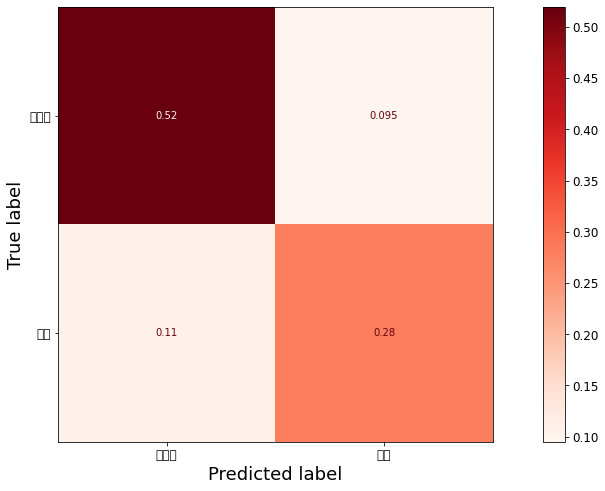

In [24]:
from sklearn.datasets import make_classification
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(clf,valid_x,valid_y,cmap="Reds",display_labels=["非生存","生存"],normalize="all")
plt.show()

TP(正解=1、予測=1)とFP(正解=0、予測=0)の割合を確認。意外とTPを当てることが出来ていそう。

In [25]:
# モデルパラメーターの確認
model.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 500,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 0,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [26]:
# 係数確認
coef = pd.DataFrame()
coef["features"] = model.feature_names_in_
coef["coef"] = model.coef_[0]
coef

,features,coef
0,PassengerId,0.000069
1,Pclass,-0.688117
2,Sex,-2.476387
3,Age,-0.012468
4,Embarked,-0.100756
5,Deck,-0.027909
6,FamilySize,-0.256048
7,Fare_log,0.252880
8,honorific_titles,-0.156485


In [41]:
#切片確認
print("Intercept =",model.intercept_[0])

Intercept = 4.395576788612433


In [43]:
# 提出

test = pd.read_csv("/kaggle/input/titanic/test.csv")

test = data_prep(test,"xgb")

test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PassengerId       418 non-null    int64  
 1   Pclass            418 non-null    int64  
 2   Sex               418 non-null    int64  
 3   Age               332 non-null    float64
 4   Fare              417 non-null    float64
 5   Embarked          418 non-null    int64  
 6   Deck              418 non-null    int64  
 7   FamilySize        418 non-null    int64  
 8   honorific_titles  418 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 29.5 KB


In [92]:
test['Age'] =  test['Age'].fillna(-1)
test['Fare'] =  test['Fare'].fillna(-1)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PassengerId       418 non-null    int64  
 1   Pclass            418 non-null    int64  
 2   Sex               418 non-null    int64  
 3   Age               418 non-null    float64
 4   Fare              418 non-null    float64
 5   Embarked          418 non-null    int64  
 6   Deck              418 non-null    int64  
 7   FamilySize        418 non-null    int64  
 8   honorific_titles  418 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 29.5 KB


In [93]:
y_pred = clf.predict(test_forl_logistic_reg)

#データフレームを作成
submission = pd.DataFrame({'PassengerId':test_forl_logistic_reg['PassengerId'], 'Survived':y_pred})
submission.head()

